In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import distances
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import parallel
from uf3.util import plotting

# $\text{UF}_{2}$ Demo: Elemental tungsten

**Data split**
- Training set: 1939 configurations (stratified 20% of the dataset)

- Holdout: 7754 configurations (remaining 80%)

**Inputs**
- ```w-14.xyz``` (30 mb)
- ```training_idx.txt``` (10 kb, included for reproducibility purposes)

**Outputs**
- ```model_pair.json``` (1 kb)
- ```W_pair.table``` (32 kb)

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

 Step             | Estimated Time 
:-----------------|:--------------
Preprocessing     | 10 seconds
Pair distribution | 10 seconds
Featurization     | 5 core-minutes (parallelizable)
Training          | 1 second
Prediction        | 1 second
Plotting          | 9 seconds

# User Parameters

```element_list (list)```: list of element symbols

```degree (int)```: truncation of many-body expansion. A value of 2 yields a pair potential.

In [5]:
element_list = ['W']
degree = 2

Initialize the ```ChemicalSystem``` and inspect interactions.

Elements involved in each interactions are sorted by electronegativity.

In [6]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print(chemical_system)

ChemicalSystem:
    Elements: ('W',)
    Degree: 2
    Pairs: [('W', 'W')]


```r_min_map (dict)```: map of minimum pair distance per interaction (angstroms). 
    If unspecified, defaults to 1.0 for all interactions.
    
```r_max_map (dict)```: map of maximum pair distance per interaction (angstroms). 
    If unspecified, defaults to 6.0 angstroms for all interactions, which probably encompasses at least 2nd-nearest neighbors.
    
```resolution_map (dict)```: map of resolution (number of knot intervals) per interaction. 
    For the cubic basis, the number of basis functions equals three more than the number of knot intervals.
    This is, in turn, negated by ```trailing_trim```.
    If unspecified, defaults to 20 for all two-body interactions and 5 for three-body interactions.
    
```trailing_trim (int)```: number of trailing basis functions to trim, defaults to 3.
 - ```= 0```: hard cutoff at ```r_max```
 - ```= 1```: function goes to zero at ```r_max```
 - ```= 2```: first derivative goes to zero at ```r_max```
 - ```= 3```: second derivative goes to zero at ```r_max```
 
```leading_trim (int)```: similar for leading basis functions (small distances).

In [7]:
r_min_map = {('W', 'W'): 0.001,
            }
r_max_map = {('W', 'W'): 5.5,
            }
resolution_map = {('W', 'W'): 15,
                 }
trailing_trim = 3
leading_trim = 0

# Demo parameters
```n_cores```: number of workers to use in parallel for feature generation

```data_filename```: filename of reference data including geometries, energies, forces, ...

```training_1939```: list of integers corresponding to entries to use for training.

In [8]:
n_cores = 4

In [9]:
example_directory = os.getcwd()
data_filename = os.path.join(example_directory, "w-14.xyz")
with open(os.path.join(example_directory, "training_idx.txt"), "r") as f:
    training_1939 = [int(idx) for idx in f.read().splitlines()]

# Initialize basis

In [10]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      resolution_map=resolution_map,
                                      leading_trim=leading_trim,
                                      trailing_trim=trailing_trim)

print(bspline_config)

BSplineBasis:
    Basis functions:
        ('W', 'W'): 18
ChemicalSystem:
    Elements: ('W',)
    Degree: 2
    Pairs: [('W', 'W')]


```bspline_config.get_interaction_partitions()``` yields the number of coefficients for each n-body interaction (one-body terms, two-body terms, three-body terms, ...) as well as the starting index in the coefficient vector for each interaction.

In [11]:
bspline_config.get_interaction_partitions()[0]

{'W': 1, ('W', 'W'): 18}

In [12]:
bspline_config.get_interaction_partitions()[1]

{'W': 0, ('W', 'W'): 1}

Text(0.5, 1.0, "Basis functions: ('W', 'W')")

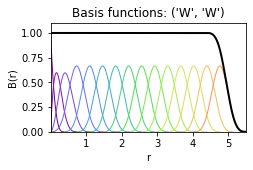

In [13]:
pair = bspline_config.interactions_map[2][0]
k_plot = bspline_config.knots_map[pair][: -3]
c_plot = np.ones(len(k_plot) - 4)

fig, ax = plt.subplots(figsize=(3.5, 2))
plotting.visualize_basis_functions(c_plot, 
                                   k_plot,
                                   ax=ax)
plotting.visualize_pair_potential(c_plot,
                                  k_plot,
                                  color="black",
                                  ax=ax)
plt.ylim(0, 1.1)
plt.title(f"Basis functions: {str(pair)}")

# Load data

In [14]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_trajectory(data_filename,
                                           prefix='dft')
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 9693
Number of forces: 475578


In [15]:
df_data.head()

,geometry,energy,fx,fy,fz,size
dft_0,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.194835,[0.0],[0.0],[0.0],1.0
dft_1,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.126991,[0.0],[0.0],[0.0],1.0
dft_2,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.133282,[0.0],[0.0],[0.0],1.0
dft_3,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.139626,[0.0],[0.0],[0.0],1.0
dft_4,"(Atom('W', [0.0, 0.0, 0.0], index=0))",-11.142003,[0.0],[0.0],[0.0],1.0


# Examine pair distance distribution
Useful step that serves as a sanity check for selected cutoffs and resolution.

In [16]:
from uf3.data import analyze
from tqdm.auto import tqdm

In [17]:
analyzer = analyze.DataAnalyzer(chemical_system, 
                                r_cut=10.0,
                                bins=0.01)

In [18]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
analyzer.load_entries(df_slice)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [19]:
analysis = analyzer.analyze(smooth=True,
                            filter_width=101,
                            filter_degree=3)

    Smallest observed: 2.02 angstroms
    Suggested Cutoffs: [3.555 4.16  4.905 5.555 6.04  6.45  6.805 7.365 7.74  7.9   8.175 8.585
 8.88  9.15 ]


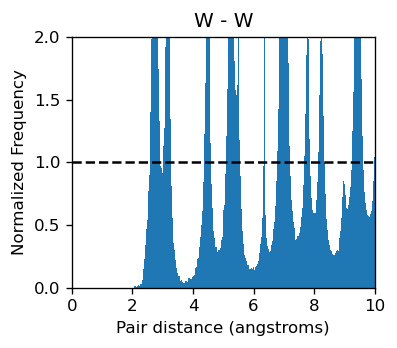

In [20]:
canvases = plotting.plot_pair_distributions(analysis, show_cutoffs=False)
for fig, ax in canvases:
    fig.set_dpi(120)
    fig.tight_layout()
    # fig.show()

# Compute energy and force features

In [21]:
representation = process.BasisFeaturizer(bspline_config)

In [22]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [23]:
n_batches = n_cores * 16  # added granularity for more progress bar updates
df_features = representation.evaluate_parallel(df_data,
                                               client,
                                               energy_key=data_coordinator.energy_key,
                                               n_jobs=n_batches)

  0%|          | 0/64 [00:00<?, ?it/s]

In [24]:
df_features.head()

y  n_W  WW0  WW1  WW2  WW3  WW4  WW5  WW6           WW7  \
dft_0 energy -11.194835  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.562682e-01   
      fx_0     0.000000  0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.000000e+00   
      fy_0     0.000000  0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0  2.775558e-17   
      fz_0     0.000000  0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -2.775558e-17   
dft_1 energy -11.126991  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  8.745162e-02   

                       WW8           WW9          WW10          WW11  \
dft_0 energy  3.814984e+00  6.083338e+00  3.640668e+00  3.047422e-01   
      fx_0   -3.475846e-17  1.881809e-17 -7.720198e-17 -0.000000e+00   
      fy_0    7.626384e-17  1.881809e-17  6.064743e-18  3.763120e-17   
      fz_0   -0.000000e+00 -0.000000e+00  2.220446e-16 -0.000000e+00   
dft_1 energy  3.148796e+00  6.107877e+00  4.016702e+00  6.389270e-01   

                  WW12          WW13          WW14  WW15  WW16  WW17  
dft_0 energy  0.789208  7.261185e+00  4.845617e+00   0.0   0.0   0.0  
      fx_0   -0.000000  1.110223e-16  3.330669e-16  -0.0  -0.0  -0.0  
      fy_0   -0.000000 -0.000000e+00  7.771561e-16  -0.0  -0.0  -0.0  
      fz_0   -0.000000 -1.110223e-16  3.330669e-16  -0.0  -0.0  -0.0  
dft_1 energy  0.442822  5.845941e+00  5.884295e+00   0.0   0.0   0.0

# Fit model
Train with 20% of the dataset (1939 samples)

In [25]:
training_keys = df_data.index[training_1939]
df_slice = df_features.loc[training_keys]
n_elements = len(chemical_system.element_list)

x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_slice,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

In [26]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=1e-6,
                                                       ridge_2b=0.0,
                                                       curvature_2b=1e-8)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

In [27]:
model.fit(x_e, y_e, x_f, y_f, weight=0.5)

In [28]:
pair = ("W", "W")

r_target = analysis["lower_bounds"][pair]
model.fix_repulsion_2b(pair, 
                       r_target=r_target,
                       min_curvature=0.0)

('W', 'W') Correction: adjusted 5 coefficients.


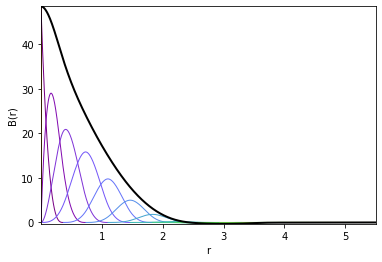

In [29]:
solutions = least_squares.arrange_coefficients(model.coefficients,
                                               bspline_config)
coefficients = solutions[("W", "W")]
knot_sequence = bspline_config.knots_map[("W", "W")]
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)
plt.vlines([0.0], -100, 100, color="orange", linewidth=2)

(-0.5, 0.5)

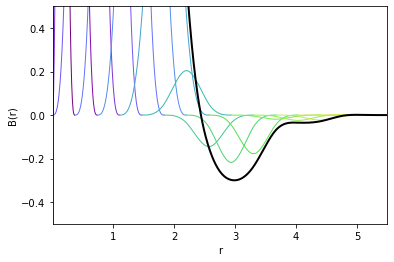

In [30]:
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)
plt.vlines([0.0], -1, 1, color="orange", linewidth=2)
ax.set_ylim(-0.5, 0.5)

# Prediction

predict with remaining 80% of dataset

In [31]:
holdout_keys = df_data.index.difference(training_keys)

In [32]:
df_holdout = df_features.loc[holdout_keys]
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_holdout,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

In [33]:
p_e = model.predict(x_e)

p_f = model.predict(x_f)

In [34]:
rmse_e = np.sqrt(np.mean(np.subtract(y_e, p_e)**2))
rmse_f = np.sqrt(np.mean(np.subtract(y_f, p_f)**2))
print(f"Energy root-mean-square error: {1000 * rmse_e:.2f} meV/atom")
print(f"Force component root-mean-square error: {1000 * rmse_f:.2f} meV/angstrom")

Energy root-mean-square error: 21.01 meV/atom
Force component root-mean-square error: 339.98 meV/angstrom


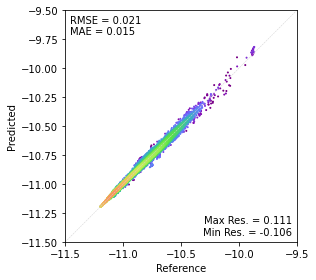

In [35]:
plotting.density_scatter(y_e, p_e)
plt.tight_layout()

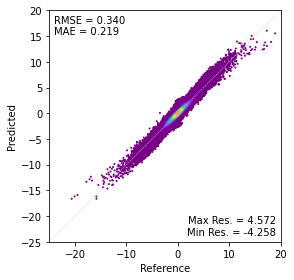

In [36]:
plotting.density_scatter(y_f, p_f)
plt.tight_layout()

# Retrain with sample weights
Provide per-sample weighting to influence the fit.

If sample_weights is provided, each training sample, including energy and
force component representations, is scaled by the weight. Missing keys
are not weighted (scaled by 1.0).

In [37]:
sample_weights = {}
df_training = df_data.loc[training_keys]

Example: increase the influence of small configurations on the fit 
(less than 10 atoms) by a factor of two.

In [38]:
for key, size in df_training[["size"]].itertuples():
    if size < 10:
        sample_weights[key] = 2.0        
print(len(sample_weights), "samples upweighted.")

406 samples upweighted.


Example: reduce the influence of configurations with large forces
by factors inversely proportional to their maximum force.

In [39]:
for key, fx, fy, fz in df_training[["fx", "fy", "fz"]].itertuples():
    force_array = np.vstack([fx, fy, fz]).T
    max_force = np.max(force_array)
    if max_force > 10:
        scale = 10 / max_force
        sample_weights[key] = scale
        print(f"{key}: {scale:.2f}")
print(len(sample_weights), "samples downweighted.")

dft_5565: 0.65
dft_8296: 0.99
dft_5345: 0.49
dft_6358: 0.84
dft_7920: 0.95
dft_6747: 0.96
dft_6150: 0.72
dft_5126: 0.91
dft_6314: 0.94
dft_5175: 0.78
dft_5385: 0.89
dft_7985: 0.56
dft_5748: 0.66
dft_6590: 0.92
dft_5745: 0.87
dft_5325: 0.77
dft_5560: 0.90
423 samples downweighted.


In [40]:
training_keys = df_data.index[training_1939]
df_slice = df_features.loc[training_keys]
n_elements = len(chemical_system.element_list)

x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_slice,
                                                       n_elements=n_elements,
                                                       energy_key="energy",
                                                       sample_weights=sample_weights)

In [41]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=1e-6,
                                                       ridge_2b=0.0,
                                                       curvature_2b=1e-8)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

In [42]:
model.fit(x_e, y_e, x_f, y_f, weight=0.5)

In [43]:
pair = ("W", "W")

r_target = analysis["lower_bounds"][pair]
model.fix_repulsion_2b(pair, 
                       r_target=r_target,
                       min_curvature=0.0)

('W', 'W') Correction: adjusted 5 coefficients.


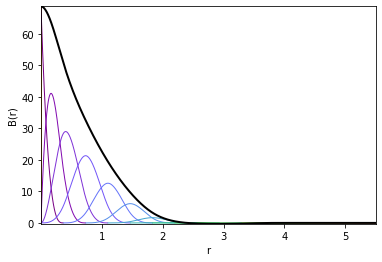

In [44]:
solutions = least_squares.arrange_coefficients(model.coefficients,
                                               bspline_config)
coefficients = solutions[("W", "W")]
knot_sequence = bspline_config.knots_map[("W", "W")]
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)
plt.vlines([0.0], -100, 100, color="orange", linewidth=2)

(-0.5, 0.5)

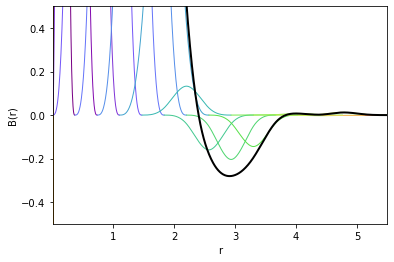

In [45]:
fig, ax = plotting.visualize_splines(coefficients, knot_sequence)
plt.vlines([0.0], -1, 1, color="orange", linewidth=2)
ax.set_ylim(-0.5, 0.5)

In [46]:
df_holdout = df_features.loc[holdout_keys]
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_holdout,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

In [47]:
p_e = model.predict(x_e)

p_f = model.predict(x_f)

In [48]:
rmse_e = np.sqrt(np.mean(np.subtract(y_e, p_e)**2))
rmse_f = np.sqrt(np.mean(np.subtract(y_f, p_f)**2))
print(f"Energy root-mean-square error: {1000 * rmse_e:.2f} meV/atom")
print(f"Force component root-mean-square error: {1000 * rmse_f:.2f} meV/angstrom")

Energy root-mean-square error: 27.86 meV/atom
Force component root-mean-square error: 314.24 meV/angstrom


# Model to/from dictionary

In [49]:
dump = model.as_dict()
dump

{'coefficients': {'W': -7.731867407983565,
  ('W',
   'W'): array([ 6.87844474e+01,  6.87844474e+01,  4.86526583e+01,  3.20298440e+01,
          1.89160046e+01,  9.17832671e+00,  2.50384426e+00,  1.99530864e-01,
         -2.40278431e-01, -3.06073057e-01, -2.16940399e-01,  2.08883166e-03,
          1.12246896e-02, -4.53185601e-03,  1.91038098e-02,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00])},
 'knots': {('W',
   'W'): array([1.0000e-03, 1.0000e-03, 1.0000e-03, 1.0000e-03, 3.6760e-01,
         7.3420e-01, 1.1008e+00, 1.4674e+00, 1.8340e+00, 2.2006e+00,
         2.5672e+00, 2.9338e+00, 3.3004e+00, 3.6670e+00, 4.0336e+00,
         4.4002e+00, 4.7668e+00, 5.1334e+00, 5.5000e+00, 5.5000e+00,
         5.5000e+00, 5.5000e+00])},
 'data_coverage': array([ True, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False, False,
        False]),
 'knot_strategy': 'linear',
 'offset_1b': True,
 'leading_trim': 0,
 'traili

In [50]:
model_copy = least_squares.WeightedLinearModel.from_dict(dump)

In [51]:
model_copy

WeightedLinearModel:
    Fit: True
BSplineBasis:
    Basis functions:
        ('W', 'W'): 18
ChemicalSystem:
    Elements: ('W',)
    Degree: 2
    Pairs: [('W', 'W')]

In [52]:
assert np.allclose(model_copy.coefficients, model.coefficients)

# Save to and load from file

In [53]:
filename = "model_2.json"
model.to_json(filename)
loaded_model = least_squares.WeightedLinearModel.from_json(filename)

In [54]:
loaded_model

WeightedLinearModel:
    Fit: True
BSplineBasis:
    Basis functions:
        ('W', 'W'): 18
ChemicalSystem:
    Elements: ('W',)
    Degree: 2
    Pairs: [('W', 'W')]

In [55]:
assert np.allclose(loaded_model.coefficients, model.coefficients)

# Compute energy, forces, stress with UFCalculator

In [56]:
calc = calculator.UFCalculator(model)

geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))

Energy: -129.94613209028597
Stresses (numerical): [-0.06135798 -0.03453627 -0.03054148  0.00298846 -0.01784534 -0.03373372]
Forces:
 [[-0.43294901  6.73603294 -0.58333983]
 [-1.33292939 -0.42635559  0.53194692]
 [ 1.35787554  1.43996832  0.41931416]
 [ 1.68800143 -5.34581649  0.41422941]
 [-0.71671663 -2.2625857  -1.20471884]
 [-1.91111338  2.27644361  0.82348654]
 [-2.17766135 -1.53650472  0.74938148]
 [ 1.37690969  0.73920866 -1.00822568]
 [ 2.10069196 -0.06056058 -0.0972426 ]
 [-0.10117589 -5.08345892  0.03573497]
 [-1.63333728  3.25637763  0.2574926 ]
 [ 1.7824043   0.26725081 -0.33805913]]
Max force: 6.736032939992704


# Relax with UFCalculator

In [57]:
geom_relaxed = calc.relax_fmax(geom, verbose=True)

                Step[ FC]     Time          Energy          fmax
*Force-consistent energies used in optimization.
BFGSLineSearch:    0[  2] 16:35:40      -37.627017*      11.8282
BFGSLineSearch:    1[  5] 16:35:40      -39.969245*      14.5948
BFGSLineSearch:    2[  9] 16:35:41      -40.381924*       7.3731
BFGSLineSearch:    3[ 13] 16:35:41      -40.641143*       2.2187
BFGSLineSearch:    4[ 17] 16:35:42      -40.681684*       1.2190
BFGSLineSearch:    5[ 22] 16:35:42      -41.292664*       4.7592
BFGSLineSearch:    6[ 25] 16:35:42      -41.534915*       2.6943
BFGSLineSearch:    7[ 27] 16:35:43      -41.616323*       1.3431
BFGSLineSearch:    8[ 29] 16:35:43      -41.628343*       0.1448
BFGSLineSearch:    9[ 32] 16:35:44      -41.629202*       0.0615
BFGSLineSearch:   10[ 36] 16:35:44      -41.629253*       0.0112


In [58]:
print("Energy:", geom_relaxed.get_potential_energy())
print("Stresses (numerical):", geom_relaxed.get_stress())
forces = geom_relaxed.get_forces()
print("Forces:\n", forces)
print("Max force:", np.max(forces))

Energy: -134.41166674096172
Stresses (numerical): [-2.96838205e-05  3.31433921e-05  5.54734982e-06 -5.06202931e-06
 -1.94573630e-05  2.54877232e-06]
Forces:
 [[ 6.01171741e-05  6.38555740e-05  1.63138252e-03]
 [ 3.14526455e-04  9.57100190e-04 -4.74538632e-04]
 [-1.01859431e-05 -1.36884488e-03 -3.25748881e-04]
 [-4.07317846e-04 -1.53982310e-03 -8.99390548e-04]
 [-1.06455180e-03  1.03706172e-03 -4.41150924e-04]
 [-1.93317204e-04  1.38752704e-03 -1.20294112e-04]
 [ 2.10584260e-04  5.01292065e-04 -3.53859755e-04]
 [-1.51164041e-04  1.12660322e-03 -4.93150960e-04]
 [ 5.05989829e-04 -6.76243459e-04  7.73158303e-04]
 [ 1.80107081e-04  5.21570383e-04 -4.62814410e-04]
 [-1.53807585e-04 -2.29449778e-03  9.23450749e-04]
 [ 7.09019621e-04  2.84399025e-04  2.42956653e-04]]
Max force: 0.0016313825166767992


# Export potential and tabulated potential

In [59]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             grid=1000,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
table_name = os.path.join(example_directory, "table_test", "W.table")
with open(table_name, "w") as f:
    f.write(combined_text)

# Compute energy, forces, stress with UFLAMMPS

**Remember to set the environment variable ``ASE_LAMMPSRUN_COMMAND``**

In [60]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)
geom = df_data.iloc[3000]['geometry'].copy()  # 12-atom cell
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Forces:\n", geom.get_forces())
print("Max force:", np.max(np.abs(geom.get_forces())))
del calc

Energy: -37.16372789033476
Stresses (numerical): [-0.06135807 -0.03453647 -0.03054176  0.00298838 -0.01784529 -0.0337337 ]
Forces:
 [[-0.4329519   6.73603289 -0.58333216]
 [-1.33292957 -0.42635554  0.53194987]
 [ 1.35787476  1.43996937  0.41931314]
 [ 1.68800081 -5.34581733  0.41422204]
 [-0.7167178  -2.26258662 -1.20471951]
 [-1.91111412  2.27644512  0.82348623]
 [-2.17765939 -1.53650329  0.74938347]
 [ 1.3769121   0.73920875 -1.0082286 ]
 [ 2.10069201 -0.06055869 -0.09724428]
 [-0.10117233 -5.08346482  0.0357333 ]
 [-1.63334123  3.25638126  0.25749692]
 [ 1.78240667  0.2672489  -0.33806042]]
Max force: 6.736032890604939


In [61]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff * * table_test/W.table UF_W-W 5.5"],
                       keep_alive=True)
calc.relax(geom)
print('Relaxation Steps:', calc.results['nsteps'])
geom.calc = calc
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
lammps_forces = geom.get_forces()
print("Forces:\n", lammps_forces)
print("Max force:", np.max(lammps_forces))
del calc

Relaxation Steps: 96
Energy: -40.45526970514733
Stresses (numerical): [-0.03056265  0.00534184  0.02522052  0.00658642 -0.01849611 -0.04036679]
Forces:
 [[-0.00932412  0.00108845  0.0037133 ]
 [-0.00770538  0.00916022 -0.001408  ]
 [ 0.01600974  0.00277239 -0.0029679 ]
 [ 0.00052542 -0.00275431 -0.00184305]
 [-0.01227637  0.00703248  0.00533529]
 [ 0.00683997 -0.00875213  0.00534898]
 [ 0.00657954 -0.00175415 -0.00487387]
 [ 0.00421104  0.00285633 -0.00125897]
 [ 0.000371   -0.00499479 -0.00232729]
 [ 0.00617072 -0.00231353 -0.00279275]
 [-0.00311078  0.00403531  0.00084746]
 [-0.00829078 -0.00637626  0.0022268 ]]
Max force: 0.016009737113210867
